<a href="https://colab.research.google.com/github/HarleenSaini19/Resistor-Value-Recognizer-RVR/blob/master/AI_Road_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import PIL
import PIL.Image
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.14.0


In [ ]:
# Dataset: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection/data
data_dir = pathlib.Path('./dataset')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

834


In [ ]:
# Classes
crosswalk = list(data_dir.glob('crosswalk/*'))
speed_limit = list(data_dir.glob('speed_limit/*'))
stop = list(data_dir.glob('stop/*'))
traffic_light = list(data_dir.glob('traffic_light/*'))

# PIL.Image.open(str(crosswalk[0]))
# PIL.Image.open(str(speed_limit[0]))
# PIL.Image.open(str(stop[0]))
# PIL.Image.open(str(traffic_light[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 832 files belonging to 4 classes.
Using 666 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 832 files belonging to 4 classes.
Using 166 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['crosswalk', 'speed_limit', 'stop', 'traffic_light']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.1002153 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = 4 #define the number of classes to 4

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #this randomly drops out a number of outputsduring the training process which further decreses overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [ ]:
epochs = 50 #the more epochs that is run, the better the accuracy but it will take more time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=0
  )

Text(0.5, 1.0, 'Training and Validation Loss')

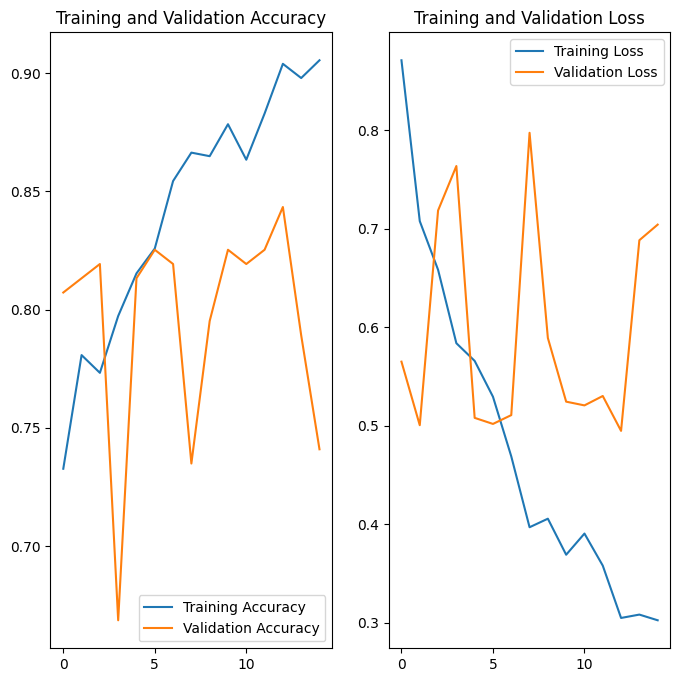

In [ ]:
#Visualize the training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
test_image_path = './datset/test/test_1.jpg'

img = keras.preprocessing.image.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to crosswalk with a 99.98 percent confidence.
